<a href="https://colab.research.google.com/github/adityabhu96/email-classification-/blob/master/Email_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Email Spam-Ham Classifier

Our first target is to fetch the data:

In [0]:
import os
import tarfile
from six.moves import urllib

DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("datasets", "spam")

def fetch_spam_data(spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", HAM_URL), ("spam.tar.bz2", SPAM_URL)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=SPAM_PATH)
        tar_bz2_file.close()

In [0]:
fetch_spam_data()

Now we will load all the emails:

In [0]:
HAM_DIR = os.path.join(SPAM_PATH, "easy_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

In [0]:
len(ham_filenames)

2500

In [0]:
len(spam_filenames)

500

We can use Python's `email` module to parse these emails (this handles headers, encoding, and so on):

In [0]:
import email
import email.policy

def load_email(is_spam, filename, spam_path=SPAM_PATH):
    directory = "spam" if is_spam else "easy_ham"
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

In [0]:
ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]

In [0]:
type(ham_emails[2])

email.message.EmailMessage

Let's look at one example of ham and one example of spam, to get a feel of what the data looks like:

In [0]:
print(ham_emails[3].get_content().strip())

Klez: The Virus That Won't Die
 
Already the most prolific virus ever, Klez continues to wreak havoc.

Andrew Brandt
>>From the September 2002 issue of PC World magazine
Posted Thursday, August 01, 2002


The Klez worm is approaching its seventh month of wriggling across 
the Web, making it one of the most persistent viruses ever. And 
experts warn that it may be a harbinger of new viruses that use a 
combination of pernicious approaches to go from PC to PC.

Antivirus software makers Symantec and McAfee both report more than 
2000 new infections daily, with no sign of letup at press time. The 
British security firm MessageLabs estimates that 1 in every 300 
e-mail messages holds a variation of the Klez virus, and says that 
Klez has already surpassed last summer's SirCam as the most prolific 
virus ever.

And some newer Klez variants aren't merely nuisances--they can carry 
other viruses in them that corrupt your data.

...

http://www.pcworld.com/news/article/0,aid,103259,00.asp
____

In [0]:
print(spam_emails[6].get_content().strip())

Help wanted.  We are a 14 year old fortune 500 company, that is
growing at a tremendous rate.  We are looking for individuals who
want to work from home.

This is an opportunity to make an excellent income.  No experience
is required.  We will train you.

So if you are looking to be employed from home with a career that has
vast opportunities, then go:

http://www.basetel.com/wealthnow

We are looking for energetic and self motivated people.  If that is you
than click on the link and fill out the form, and one of our
employement specialist will contact you.

To be removed from our link simple go to:

http://www.basetel.com/remove.html


4139vOLW7-758DoDY1425FRhM1-764SMFc8513fCsLl40


Some emails are actually multipart, with images and attachments (which can have their own attachments). Let's look at the various types of structures we have:

In [0]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

In [0]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [0]:
structures_counter(ham_emails).most_common()

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [0]:
structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

It seems that the ham emails are more often plain text, while spam has quite a lot of HTML. Moreover, quite a few ham emails are signed using PGP (Pretty Good Privacy), while no spam is. In short, it seems that the email structure is useful information to have.

Now let's take a look at the email headers:

In [0]:
for header, value in spam_emails[0].items():
    print(header,":",value)

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

There's probably a lot of useful information in there, such as the sender's email address (12a1mailbot1@web.de looks fishy), but we will just focus on the `Subject` header:

In [0]:
spam_emails[0]["Subject"]

'Life Insurance - Why Pay More?'

Okay, before we learn too much about the data, let's not forget to split it into a training set and a test set:

In [0]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails + spam_emails)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Okay, let's start writing the preprocessing functions. First, we will need a function to convert HTML to plain text. Arguably the best way to do this would be to use the great [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) library, but I would like to avoid adding another dependency to this project, so let's hack a quick & dirty solution using regular expressions (at the risk of [un̨ho͞ly radiańcé destro҉ying all enli̍̈́̂̈́ghtenment](https://stackoverflow.com/a/1732454/38626)). The following function first drops the `<head>` section, then converts all `<a>` tags to the word HYPERLINK, then it gets rid of all HTML tags, leaving only the plain text. For readability, it also replaces multiple newlines with single newlines, and finally it unescapes html entities (such as `&gt;` or `&nbsp;`):

In [0]:
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

Let's see if it works. This is HTML spam:

In [0]:
html_spam_emails = [email for email in X_train[y_train==1]
                    if get_email_structure(email) == "text/html"]
sample_html_spam = html_spam_emails[8]
print(sample_html_spam.get_content().strip()[:1000], "...")

<HTML><HEAD><TITLE>MILFhunter</TITLE>
<META http-equiv=Content-Type
content="text/html; charset=windows-1252"><HTTP-EQUIV="PRAGMA"
CONTENT="NO-CACHE">
<SCRIPT language=JavaScript>
<!-- hide from old browsers
	function loadPage(pageURL){
	location.href = pageURL.options[pageURL.selectedIndex].value
	}
//-->
</SCRIPT>

<META content="MSHTML 6.00.2716.2200" name=GENERATOR></HEAD>
<BODY text=#eaebec vLink=#ffffcc aLink=#ffffff link=#ffffcc bgColor=#647481
leftMargin=0 background="http://www.fromyou2.com/nasty/milf/bg.jpg"
topMargin=0>
<CENTER><BR>
  <CENTER>
    <CENTER>
      <FONT face=verdana><BR>
      </FONT>
      <CENTER>
        <TABLE cellPadding=15 bgColor=gray>
          <TBODY>
          <TR>
            <TD>
              <CENTER>
                <font color="black" face="verdana"><A
      onmouseover="window.status='MILFhunter.com - Do you know where your mom is?';return true"
      href="http://www.fromyou2.com/nasty/milf/milf/bindex.htm"><IMG
      src="http://www.fromyou2.

And this is the resulting plain text:

In [0]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")


                 HYPERLINK
                     HYPERLINK
                     HYPERLINK
                     HYPERLINK
                     HYPERLINK
                     HYPERLINK
                     HYPERLINK
                     HYPERLINK
                     HYPERLINK
                     HYPERLINK
                     HYPERLINK
                     HYPERLINK
                     HYPERLINK
                     HYPERLINK
                     HYPERLINK
                     HYPERLINK
                     HYPERLINK
                 HYPERLINK MILF HUNTER
                Do you know where your mom is?
                 HYPERLINK
                MORE SAMPLE PICS      MORE SAMPLE MOVIES      LIST OF MILFs
         
         HYPERLINK CLICK
          HERE to enlarge your PENIS 3-4 inches NATURALLY!!
         
         
         HYPERLINK Click
          Here to be removed
 ...


Great! Now let's write a function that takes an email as input and returns its content as plain text, whatever its format is:

In [0]:
def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

In [0]:
print(email_to_text(sample_html_spam)[:100], "...")


                 HYPERLINK
                     HYPERLINK
                     HYPERLINK
           ...


Let's throw in some stemming! For this to work, you need to install the Natural Language Toolkit ([NLTK](http://www.nltk.org/)). It's as simple as running the following command (don't forget to activate your virtualenv first; if you don't have one, you will likely need administrator rights, or use the `--user` option):

`$ pip3 install nltk`

In [0]:
try:
    import nltk

    stemmer = nltk.PorterStemmer()
    for word in ("Compulsions", "Computation", "Corporative", "Computing", "Compute", "Compulsive", "Corporation"):
        print(word, "=>", stemmer.stem(word))
except ImportError:
    print("Error: stemming requires the NLTK module.")
    stemmer = None

Compulsions => compuls
Computation => comput
Corporative => corpor
Computing => comput
Compute => comput
Compulsive => compuls
Corporation => corpor


We will also need a way to replace URLs with the word "URL". For this, we could use hard core [regular expressions](https://mathiasbynens.be/demo/url-regex) but we will just use the [urlextract](https://github.com/lipoja/URLExtract) library. You can install it with the following command (don't forget to activate your virtualenv first; if you don't have one, you will likely need administrator rights, or use the `--user` option):

`$ pip3 install urlextract`

In [0]:
try:
    import urlextract # may require an Internet connection to download root domain names
    
    url_extractor = urlextract.URLExtract()
    print(url_extractor.find_urls("Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"))
except ImportError:
    print("Error: replacing URLs requires the urlextract module.")
    url_extractor = None

Error: replacing URLs requires the urlextract module.


We are ready to put all this together into a transformer that we will use to convert emails to word counters. Note that we split sentences into words using Python's `split()` method, which uses whitespaces for word boundaries. This works for many written languages, but not all. For example, Chinese and Japanese scripts generally don't use spaces between words, and Vietnamese often uses spaces even between syllables. It's okay in this exercise, because the dataset is (mostly) in English.

In [0]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*(?:[eE]\d+))?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

Let's try this transformer on a few emails:

In [0]:
X_few = X_train[:4]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'chuck': 1, 'murcko': 1, 'wrote': 1, 'stuff': 1, 'yawn': 1, 'r': 1}),
       Counter({'the': 11, 'of': 9, 'and': 8, 'all': 3, 'christian': 3, 'to': 3, 'by': 3, 'jefferson': 2, 'i': 2, 'have': 2, 'superstit': 2, 'one': 2, 'on': 2, 'been': 2, 'ha': 2, 'half': 2, 'rogueri': 2, 'teach': 2, 'jesu': 2, 'some': 1, 'interest': 1, 'quot': 1, 'http': 1, 'www': 1, 'postfun': 1, 'com': 1, 'pfp': 1, 'worboi': 1, 'html': 1, 'thoma': 1, 'examin': 1, 'known': 1, 'word': 1, 'do': 1, 'not': 1, 'find': 1, 'in': 1, 'our': 1, 'particular': 1, 'redeem': 1, 'featur': 1, 'they': 1, 'are': 1, 'alik': 1, 'found': 1, 'fabl': 1, 'mytholog': 1, 'million': 1, 'innoc': 1, 'men': 1, 'women': 1, 'children': 1, 'sinc': 1, 'introduct': 1, 'burnt': 1, 'tortur': 1, 'fine': 1, 'imprison': 1, 'what': 1, 'effect': 1, 'thi': 1, 'coercion': 1, 'make': 1, 'world': 1, 'fool': 1, 'other': 1, 'hypocrit': 1, 'support': 1, 'error': 1, 'over': 1, 'earth': 1, 'six': 1, 'histor': 1, 'american': 1, 'john': 1, 'e': 1, 're

This looks about right!

Now we have the word counts, and we need to convert them to vectors. For this, we will build another transformer whose `fit()` method will build the vocabulary (an ordered list of the most common words) and whose `transform()` method will use the vocabulary to convert word counts to vectors. The output is a sparse matrix.

In [0]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000):
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None):
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.most_common_ = most_common
        self.vocabulary_ = {word: index + 1 for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None):
        rows = []
        cols = []
        data = []
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)), shape=(len(X), self.vocabulary_size + 1))

In [0]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10)
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors

<4x11 sparse matrix of type '<class 'numpy.int64'>'
	with 27 stored elements in Compressed Sparse Row format>

In [0]:
X_few_vectors.toarray()

array([[  6,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [110,   3,  11,   9,   8,   1,   0,   1,   2,   3,   1],
       [ 96,   3,   0,   1,   2,   4,   5,   3,   0,   1,   2],
       [ 55,   6,   1,   1,   1,   0,   0,   0,   2,   0,   1]],
      dtype=int64)

In [0]:
vocab_transformer.vocabulary_

{'all': 9,
 'and': 4,
 'com': 7,
 'http': 5,
 'i': 8,
 'in': 10,
 'number': 6,
 'of': 3,
 'the': 2,
 'to': 1}

We are now ready to train our first spam classifier! Let's transform the whole dataset:

#LOGISTIC REGRESSION

In [0]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3, scoring='accuracy')
score.mean()

0.9866666666666667

In [0]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(random_state=42)
log_clf.fit(X_train_transformed, y_train)
y_pred = log_clf.predict(X_test_transformed)

print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred)))

Precision: 97.89%
Recall: 97.89%


In [0]:
conf_mat = confusion_matrix(y_test, y_pred)

In [0]:
conf_mat

array([[503,   2],
       [  2,  93]])

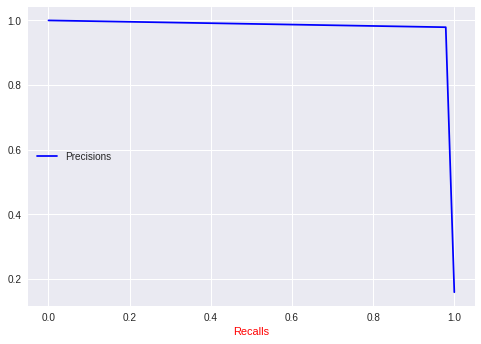

In [0]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
precisions,recalls,threshold= precision_recall_curve(y_test,y_pred)
def plot_precision_v_recall(recalls,precisions):
  plt.plot(recalls,precisions,'b-',label='Precisions')
  plt.xlabel('Recalls',color='r')
  plt.legend(loc='center left')
plot_precision_v_recall(recalls,precisions)

#SGD Classifier

In [0]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train_transformed, y_train)
y_pred_sgd= sgd_clf.predict(X_test_transformed)
print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred_sgd)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred_sgd)))

Precision: 91.11%
Recall: 86.32%


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [0]:
score_sgd= cross_val_score(sgd_clf, X_train_transformed, y_train,cv=3, scoring='accuracy')
score_sgd.mean()

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/usr/local/lib/python3.6/dist-packages/s

0.9516666666666667

In [0]:
conf_mat_sgd = confusion_matrix(y_test,y_pred_sgd)
conf_mat_sgd

array([[497,   8],
       [ 13,  82]])

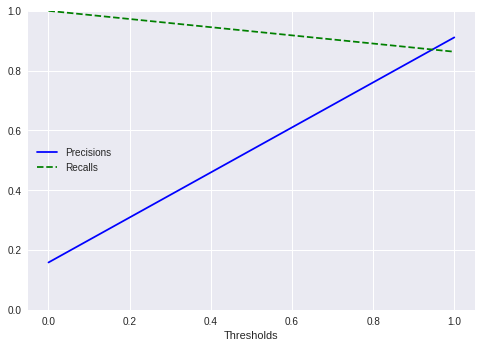

In [0]:
precisions_sgd,recalls_sgd,thresholds_sgd= precision_recall_curve(y_test,y_pred_sgd)
def plot_precision_recall_v_threshold(precisions,recalls,thresholds):
  plt.plot(thresholds_sgd,precisions_sgd[:-1],'b-',label='Precisions')
  plt.plot(thresholds_sgd, recalls_sgd[:-1],'g--',label='Recalls')
  plt.xlabel('Thresholds')
  plt.legend(loc='center left')
  plt.ylim(0,1)
plot_precision_recall_v_threshold(precisions_sgd,recalls_sgd,thresholds_sgd)

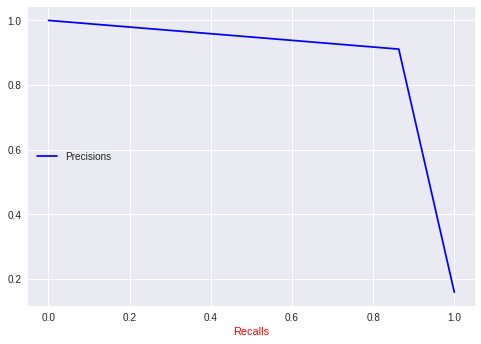

In [0]:
def plot_precision_v_recall(recalls,precisions):
  plt.plot(recalls_sgd,precisions_sgd,'b-',label='Precisions')
  plt.xlabel('Recalls',color='r')
  plt.legend(loc='center left')
plot_precision_v_recall(recalls_sgd,precisions_sgd)

#Random Forest Classifier

In [0]:
from sklearn.ensemble import RandomForestClassifier
rand_clf = RandomForestClassifier(n_estimators=800, max_features=500, random_state=42)
rand_clf.fit(X_train_transformed, y_train)
y_pred_rand= rand_clf.predict(X_test_transformed)
print("Precision: {:.2f}%".format(100 * precision_score(y_test, y_pred_rand)))
print("Recall: {:.2f}%".format(100 * recall_score(y_test, y_pred_rand)))

Precision: 97.75%
Recall: 91.58%


In [0]:
score_rand= cross_val_score(rand_clf, X_train_transformed, y_train,cv=3, scoring='accuracy')
score_rand.mean()

0.9808333333333333

In [0]:
conf_mat_rand = confusion_matrix(y_test,y_pred_rand)
conf_mat_rand

array([[503,   2],
       [  8,  87]])

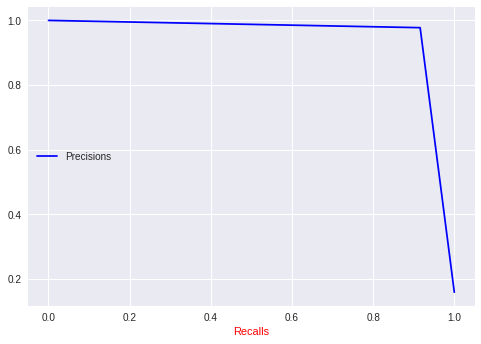

In [0]:
import matplotlib.pyplot as plt
precisions_rand,recalls_rand,threshold_rand= precision_recall_curve(y_test,y_pred_rand)
def plot_precision_v_recall(recalls,precisions):
  plt.plot(recalls_rand,precisions_rand,'b-',label='Precisions')
  plt.xlabel('Recalls',color='r')
  plt.legend(loc='center left')
plot_precision_v_recall(recalls_rand,precisions_rand)

#Performance Comparison of different Classifiers

**Precision-Recall Curve Comparison**

Text(0.5,1,'Precision - Recall Curve Comparison')

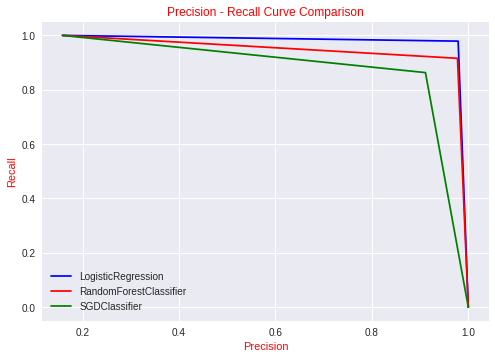

In [0]:
plt.plot(precisions,recalls,'b-',label = 'LogisticRegression')
plt.plot(precisions_rand,recalls_rand,'r-',label = 'RandomForestClassifier')
plt.plot(precisions_sgd,recalls_sgd,'g-',label = 'SGDClassifier')
plt.xlabel('Precision',color='r')
plt.ylabel('Recall',color='r')
plt.legend(loc = 0)
plt.title('Precision - Recall Curve Comparison',color='r')

**ROC_CURVE COMPARISON**

In [0]:
from sklearn.metrics import roc_curve,roc_auc_score
fpr,tpr,thresholds = roc_curve(y_test,y_pred)
fpr_sgd,tpr_sgd,threshold_sgd = roc_curve(y_test,y_pred_sgd)
fpr_rand,tpr_rand,thresholds_rand = roc_curve(y_test,y_pred_rand)

Text(0.5,1,'ROC_CURVE Comparison')

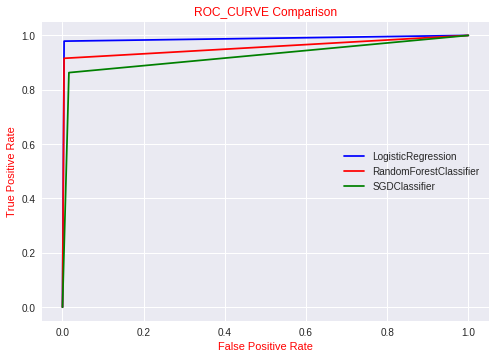

In [0]:
plt.plot(fpr,tpr,'b-',label = 'LogisticRegression')
plt.plot(fpr_rand,tpr_rand,'r-',label = 'RandomForestClassifier')
plt.plot(fpr_sgd,tpr_sgd,'g-',label = 'SGDClassifier')
plt.xlabel('False Positive Rate',color='r')
plt.ylabel('True Positive Rate',color='r')
plt.legend(loc = 'center right')
plt.title('ROC_CURVE Comparison',color='r')

**ROC_AUC_SCORE COMPARISON**

In [0]:
log_auc_score = roc_auc_score(y_test,y_pred)
sgd_auc_score = roc_auc_score(y_test,y_pred_sgd)
rand_auc_score = roc_auc_score(y_test,y_pred_rand)
print("LogisticRegression ROC_AUC_Score: {:.2f}%".format(100 * log_auc_score))
print("SGDClassifier ROC_AUC_Score: {:.2f}%".format(100 * sgd_auc_score))
print("RandomForestRegressor ROC_AUC_Score: {:.2f}%".format(100 * rand_auc_score))

LogisticRegression ROC_AUC_Score: 98.75%
SGDClassifier ROC_AUC_Score: 92.37%
RandomForestRegressor ROC_AUC_Score: 95.59%


In [0]:
LogisticRegression ROC_AUC_Score: 98.75%
SGDClassifier ROC_AUC_Score: 92.37%
  
RandomForestRegressor ROC_AUC_Score: 95.59%
  8.	SPLITTING THE DATSET INTO TRAIN AND TEST SETS:
    9.	CONVERTING HTML TO PLAIN TEXT:
      CONVERTING EMAILS TO WORD COUNTERS:
        WORD COUNTER TO VECTOR TRANFORMER (SPARSE MATRIX):
          PIPELINE TO TRANSFORM THE DATASET:
            USING DIFFERENT CLASSIFIERS:
              PERFORMANCE COMPARISON OF THE CLASSIFIERS:
                14-15, 15, 16, 16-17, 17, 18-19, 20, 20-21, 21-23, 23-25, 25-27, 27, 28-29, 29-30, 31, 32, 32, 33 9883214403   8337066991